In [41]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [42]:
# test model
test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_1"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset = 'cingulate_HCP_half_2_gender'

## UMAP

In [43]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [44]:
def visualize_umaps(model_path, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], show_wrong_class=False, dataset=dataset, verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/' + dataset + "_embeddings/train_val_embeddings.csv", index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path + '/' + dataset + "_embeddings/cross_val_predicted_labels.csv", index_col=0)
    prediction_df.sort_index(inplace=True)
    
    if verbose:
        print("Data df:")
        print(data_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_model_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            if show_wrong_class:
                colors = []
                # for i in range(prediction_df.shape[0]):
                #     if prediction_df[la]

            plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

    return pd.DataFrame(visual_embs, index=data_df.index.values)

In [45]:
def cross_correlation(model_path, dataset=dataset):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/train_val_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [46]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset=dataset):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/train_val_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [47]:
def full_visualization(model_path, dataset=dataset):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

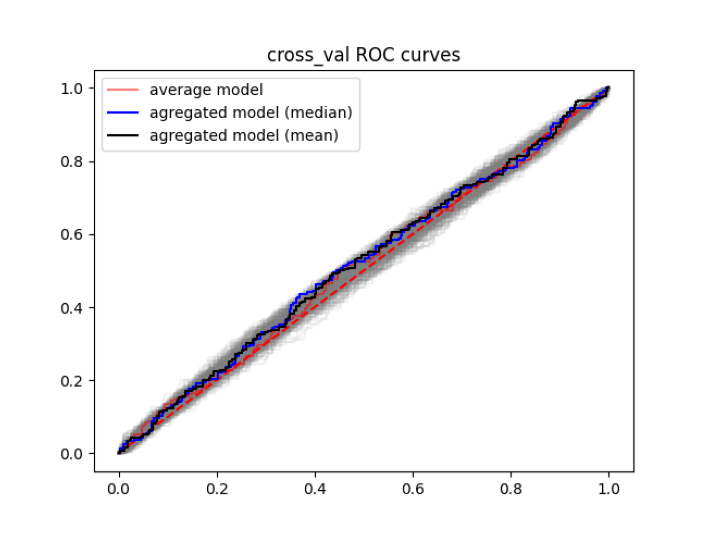

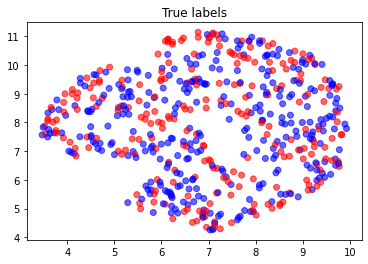

TypeError: '<=' not supported between instances of 'int' and 'numpy.ndarray'

<Figure size 12441.6x1036.8 with 0 Axes>

In [48]:
# test model
visual_embs = full_visualization(test_model)

# Visualize each variable of the latent

x, full_df and colors shapes:  (551, 10) (551, 11) (551, 10)
(10,) (10,) (10,)


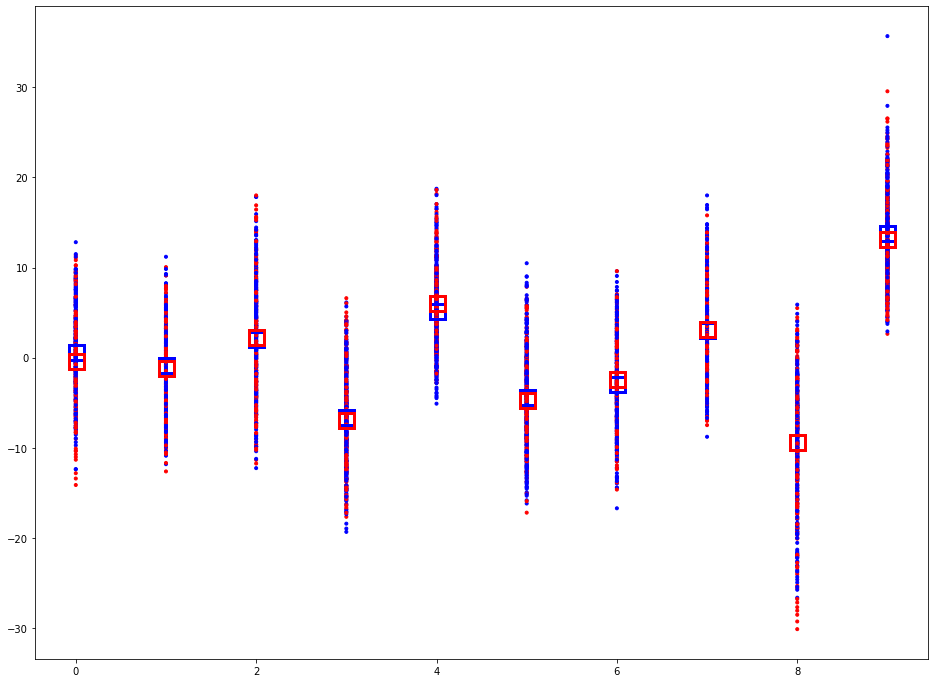

In [49]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [50]:
def do_pca(model_path, dataset=dataset):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/train_val_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [51]:
def do_dictionary_learning(model_path, dataset=dataset, n_components=10):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/train_val_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components, alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = dict_learner.transform(label0_df)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = dict_learner.transform(label1_df)

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

    return transformed0, transformed1, transformed, latent_df_normalized.values, dict_learner


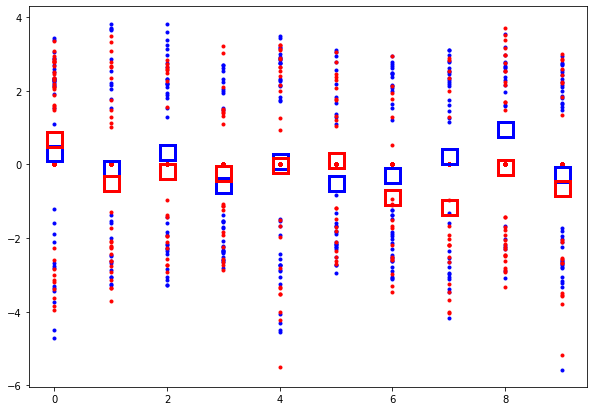

In [52]:
transformed0, transformed1, transformed, X, dict_learner = do_dictionary_learning(test_model, n_components=10)

In [53]:
print(f"sparsity = {np.mean(transformed == 0)}")
X_hat = transformed @ dict_learner.components_
print(f"reconstruction error = {np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))}")

sparsity = 0.9
reconstruction error = 0.3907121317103886


In [54]:
print(transformed[0])
len(transformed)

[ 0.          0.          0.          0.         -2.80594323  0.
  0.          0.          0.          0.        ]


551

In [55]:
data_df = pd.read_csv(test_model+'/' +dataset + '_embeddings/train_val_embeddings.csv', index_col=0)
data_df.sort_index(inplace=True)

print(transformed.shape)
print(data_df.head().iloc[:,0:5])

(551, 10)
            dim1      dim2       dim3      dim4       dim5
ID                                                        
100206  8.394083 -4.838112   6.458366 -3.329373  10.817843
100408 -0.053095 -2.919907  -3.839787 -6.310361   0.392095
101006  1.712571 -5.799995   4.553103 -0.968306  -1.620303
101410  3.489696  4.495402 -11.340138 -4.255336   3.263800
101915  3.194303  1.626097  10.028360 -8.020655   8.558414


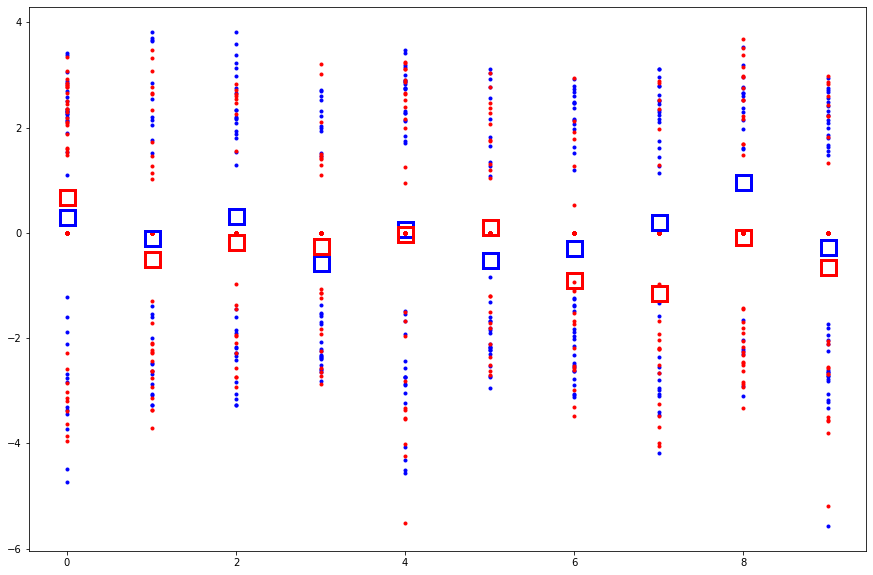

In [56]:
fig, axs = plt.subplots(1, 1, figsize=(15,10)) 

_, D = transformed0.shape

x = np.reshape(np.arange(D), (1,D))
x = np.repeat(x, transformed0.shape[0], axis=0)
axs.scatter(x, transformed0, c='blue', marker='.')
x = np.reshape(np.arange(D), (1,D))
x = np.repeat(x, transformed1.shape[0], axis=0)
axs.scatter(x, transformed1, c='red', marker='.')

x = np.arange(D)

masked0 = np.ma.masked_equal(transformed0, 0.)
mean0 = masked0.mean(axis=0)
axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

masked1 = np.ma.masked_equal(transformed1, 0.)
mean1 = masked1.mean(axis=0)
axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

plt.show()


In [57]:
def do_umap(model_path, dataset=dataset, verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/' + dataset + "_embeddings/train_val_embeddings.csv", index_col=0)
    data_df.sort_index(inplace=True)  

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
    return visual_embs

In [58]:
visual_embs = do_umap(test_model)

In [59]:
def visualize_umaps_with_dict(visual_embs, transformed, y=1, verbose=False):
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'grey', 'r']
    transformed_local = transformed.copy()
    arr = transformed_local[:,y]
    if verbose:
        print(arr)
    arr[arr>0] = 2
    arr[arr==0] = 1
    arr[arr<0] = 0
    arr = arr.astype(int)
    if verbose:
        print(arr)
    colors = [cmap[l] for l in arr]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title(f"Pattern number {y}")
    plt.show()

In [60]:
data_df = pd.read_csv(test_model+'/' + dataset + "_embeddings/train_val_embeddings.csv", index_col=0)
data_df.sort_index(inplace=True)  
data_df.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
100206,8.394083,-4.838112,6.458366,-3.329373,10.817843,-12.612897,2.753505,7.109221,-12.640517,19.555060
100408,-0.053095,-2.919907,-3.839787,-6.310361,0.392095,-7.196580,0.992875,5.049739,-10.221111,13.107022
101006,1.712571,-5.799995,4.553103,-0.968306,-1.620303,-2.390229,-2.943960,4.531745,-18.519890,21.366726
101410,3.489696,4.495402,-11.340138,-4.255336,3.263800,-5.770106,-7.426247,3.433277,-10.003428,4.795885
101915,3.194303,1.626097,10.028360,-8.020655,8.558414,0.001191,-0.200929,3.515149,-7.476232,21.969023


In [61]:
prediction_df = pd.read_csv(test_model + '/' + dataset + "_embeddings/cross_val_predicted_labels.csv", index_col=0)
prediction_df.sort_index(inplace=True)
prediction_df.head()

,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,...,predicted_243,predicted_244,predicted_245,predicted_246,predicted_247,predicted_248,predicted_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
100206,1,0.444710,0.416880,0.477898,0.422418,0.412714,0.442173,0.438144,0.462154,0.436093,...,0.380958,0.424293,0.398272,0.434572,0.430094,0.426192,0.500000,0.436527,0.436462,0.439772
100408,1,0.419168,0.431269,0.411886,0.429181,0.433191,0.421195,0.423171,0.413456,0.424011,...,0.445625,0.428954,0.439897,0.424815,0.426420,0.428043,0.400770,0.423601,0.424059,0.423313
101006,0,0.417201,0.432400,0.406891,0.429711,0.434807,0.419575,0.422011,0.409747,0.423074,...,0.450848,0.429319,0.443216,0.424058,0.426133,0.428188,0.393691,0.422521,0.423158,0.422039
101410,1,0.418233,0.431806,0.409508,0.429433,0.433959,0.420425,0.422620,0.411692,0.423565,...,0.448105,0.429128,0.441473,0.424455,0.426284,0.428112,0.397397,0.423082,0.423629,0.422707
101915,0,0.440107,0.419436,0.465917,0.423623,0.416341,0.438397,0.435454,0.453329,0.433925,...,0.392128,0.425124,0.405564,0.432823,0.429437,0.426522,0.478466,0.434188,0.434166,0.436814


In [62]:
data_df.index.difference(prediction_df.index)

Int64Index([], dtype='int64', name='ID')

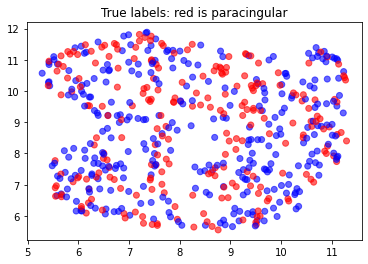

In [63]:
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels: red is paracingular")
    plt.show()

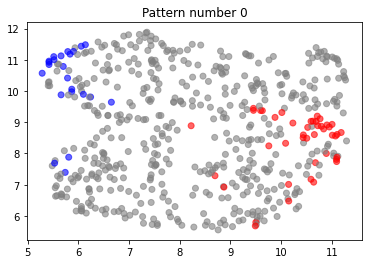

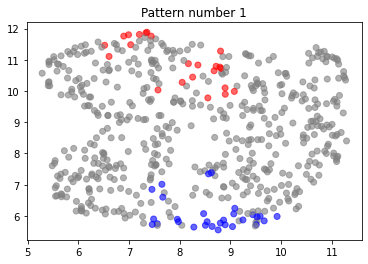

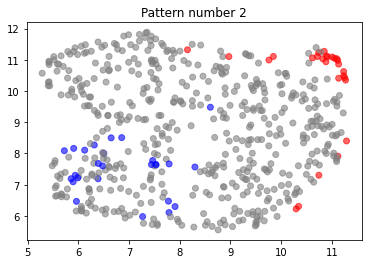

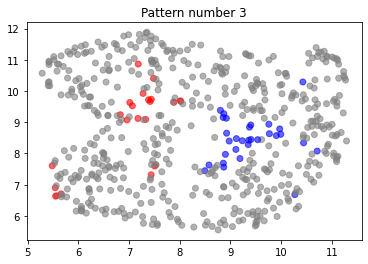

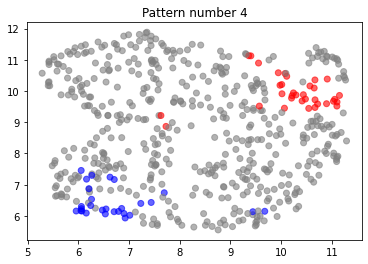

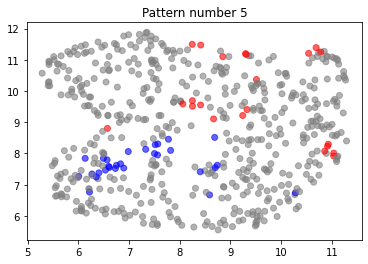

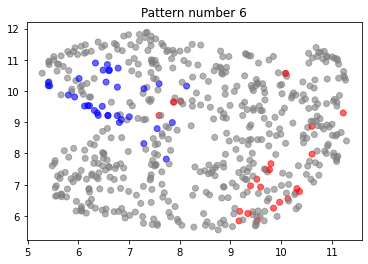

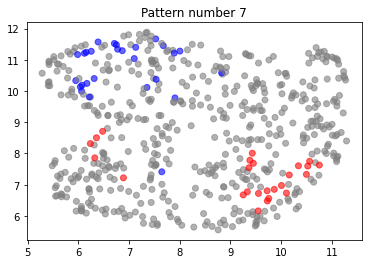

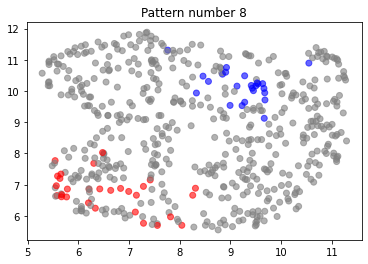

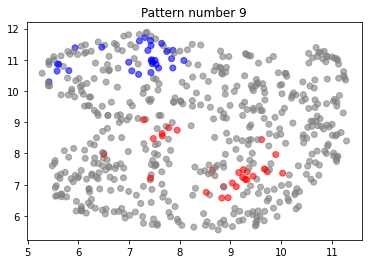

In [64]:
for i in range(10):
    visualize_umaps_with_dict(visual_embs, transformed, i, False)

In [65]:
print(transformed.shape)
print(prediction_df.label.shape)

(551, 10)
(551,)


In [66]:
def do_auc_supervised(x,y):
    y = y.copy()
    y['pred'] = x
    y = y[y.pred != 0.]
    model = SVC(kernel='linear',probability=True, max_iter=1000)
    X = y.pred.values.reshape(-1,1)
    labels_pred = model.fit(X,y.label).predict_proba(X)
    return roc_auc_score(y.label,labels_pred[:,1])

In [67]:
def do_auc_sigmoid(x,y):
    y = y.copy()
    y['pred'] = x
    y = y[y.pred != 0.]
    # We don't know which side represents the patterns=
    pred1 = 1. / (1. + np.exp(y.pred))
    auc1 = roc_auc_score(y.label,pred1)
    pred2 = 1. / (1. + np.exp(-y.pred))
    auc2 = roc_auc_score(y.label,pred2)
    return max(auc1, auc2)

In [68]:
do_auc_supervised(transformed[:,0], prediction_df[["label"]])

0.4747474747474748

In [69]:
do_auc_sigmoid(transformed[:,0], prediction_df[["label"]])

0.5252525252525253

In [70]:
latent_df = pd.read_csv(test_model+'/'+dataset+'_embeddings/train_val_embeddings.csv', index_col=0)
latent_df.sort_index(inplace=True)
latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
n_components = [1,2,4,6,8,10]
transformed_all = []
results_auc = np.zeros((len(n_components),n_components[-1]))
for i, n_component in enumerate(n_components):
    dict_learner = DictionaryLearning(n_components=n_component, transform_n_nonzero_coefs=1, alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)
    for j in range(n_component):
        results_auc[i, j] = do_auc_sigmoid(transformed[:,j], prediction_df[["label"]])
    transformed_all.append(transformed)
results_auc = -np.sort(-results_auc)
results_auc

array([[0.51747377, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.53371628, 0.50229745, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.58383534, 0.52830189, 0.5254792 , 0.51489726, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.55905906, 0.53448276, 0.53123487, 0.52832439, 0.51670507,
        0.51098191, 0.        , 0.        , 0.        , 0.        ],
       [0.62218045, 0.55592105, 0.5451505 , 0.54263566, 0.5407197 ,
        0.53708134, 0.51069519, 0.50758075, 0.        , 0.        ],
       [0.62588235, 0.5974359 , 0.58454106, 0.58018018, 0.54545455,
        0.53729604, 0.53714286, 0.52005013, 0.51339286, 0.50793651]])

<AxesSubplot:>

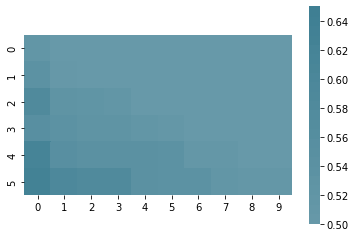

In [71]:
sns.heatmap(
        results_auc, 
        vmin=0.5, vmax=0.65, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
        )

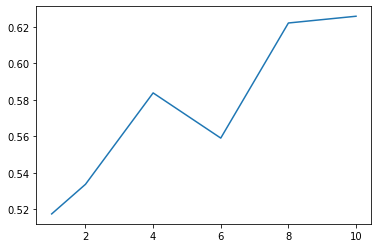

In [72]:
plt.plot(n_components, results_auc[:,0])

In [73]:
from scipy.stats import binom_test

def do_t_test(x,y):
    y = y.copy()
    y['pred'] = x
    y = y[y.pred != 0.]
    # We don't know which side represents the patterns=
    pred1 = (y.pred >0.).astype(int)
    p1 = binom_test(pred1.sum(), n=len(pred1), p=y.label.mean(), alternative='less')
    pred2 = (y.pred <0.).astype(int)
    p2 = binom_test(pred2.sum(), n=len(pred2), p=y.label.mean(), alternative='less')
    return min(p1,p2)

In [74]:
do_t_test(transformed[:,1], prediction_df[["label"]])

0.18172862801466236

In [75]:
latent_df = pd.read_csv(test_model+'/'+dataset+'_embeddings/train_val_embeddings.csv', index_col=0)
latent_df.sort_index(inplace=True)
latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
results_p = np.zeros((len(n_components),n_components[-1]))
for i, n_component in enumerate(n_components):
    for j in range(n_component):
        results_p[i, j] = do_t_test(transformed_all[i][:,j], prediction_df[["label"]])
results_p = np.sort(results_p)
results_p

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.9973398 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.96600476, 0.98499399],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.53272253, 0.66949323, 0.99648562, 0.99718907],
       [0.        , 0.        , 0.        , 0.        , 0.11200867,
        0.38999872, 0.63363888, 0.94438996, 0.99224683, 0.99967857],
       [0.        , 0.        , 0.10583823, 0.14890809, 0.19623675,
        0.82616348, 0.86480553, 0.8685537 , 0.97356395, 0.99907834],
       [0.0099479 , 0.17919378, 0.18172863, 0.34089994, 0.8640691 ,
        0.93296886, 0.95736207, 0.96086908, 0.96133474, 0.99960853]])

In [76]:
results_p[results_p==0.] = 1.
results_p = np.sort(results_p)
results_p

array([[0.9973398 , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.96600476, 0.98499399, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.53272253, 0.66949323, 0.99648562, 0.99718907, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.11200867, 0.38999872, 0.63363888, 0.94438996, 0.99224683,
        0.99967857, 1.        , 1.        , 1.        , 1.        ],
       [0.10583823, 0.14890809, 0.19623675, 0.82616348, 0.86480553,
        0.8685537 , 0.97356395, 0.99907834, 1.        , 1.        ],
       [0.0099479 , 0.17919378, 0.18172863, 0.34089994, 0.8640691 ,
        0.93296886, 0.95736207, 0.96086908, 0.96133474, 0.99960853]])

<AxesSubplot:>

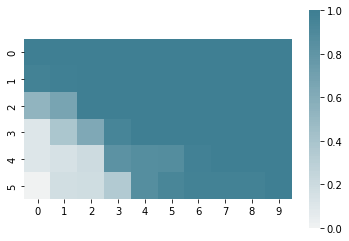

In [77]:
sns.heatmap(
        results_p, 
        vmin=0., vmax=1., center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
        )

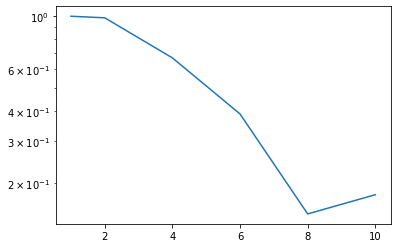

In [78]:
plt.plot(n_components, results_p[:,1])
plt.yscale('log')

(10,)
(10,)


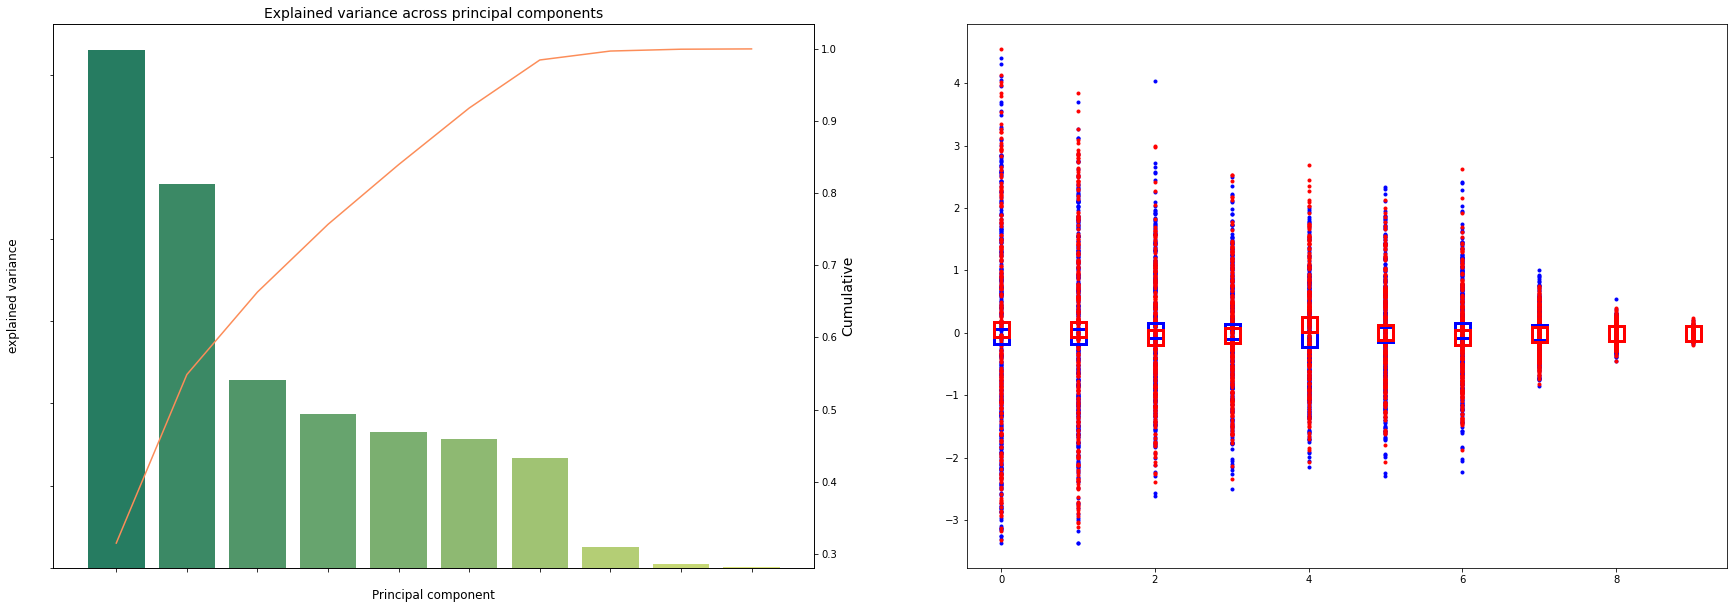

In [79]:
do_pca(test_model)

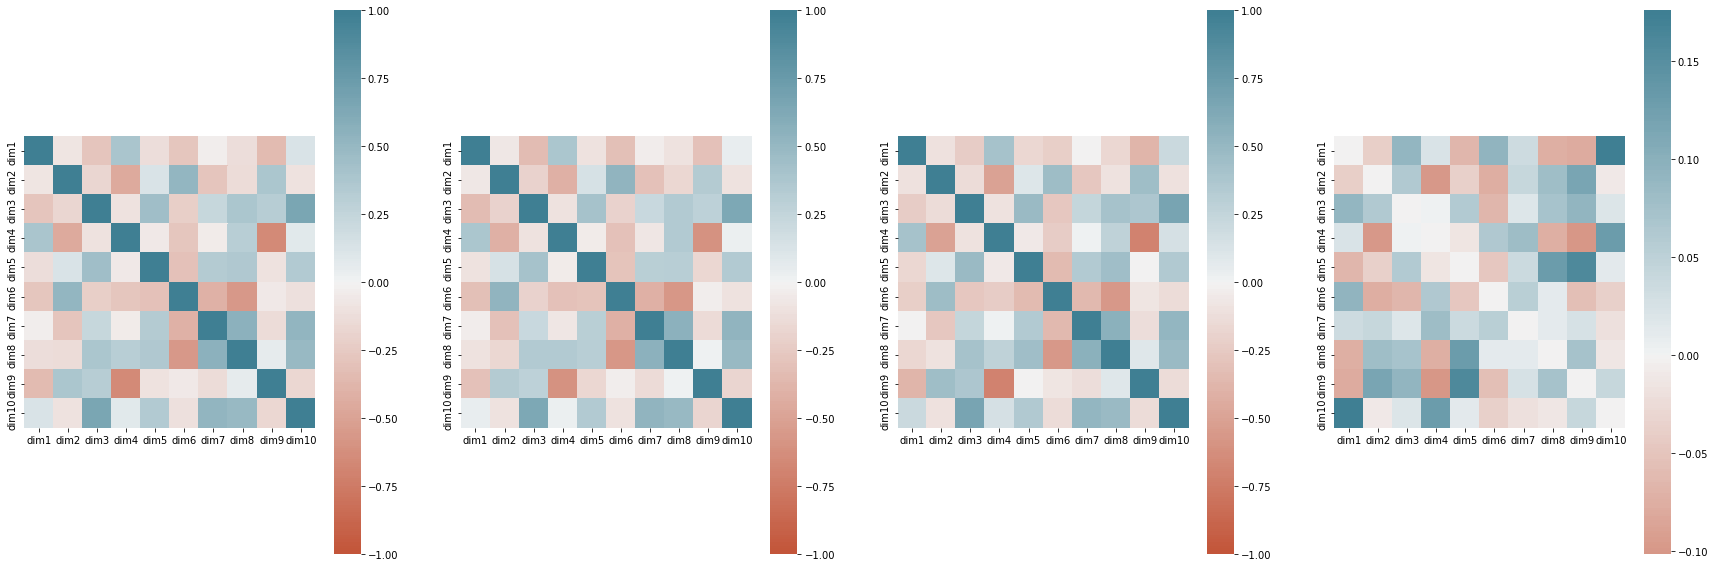

In [80]:
cross_correlation(test_model)